# Libs

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Uploading

In [2]:
# 1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. 
# Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
features_init = pd.read_csv('./final_hw/features.csv', index_col='match_id')
features_init.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [3]:
# - Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
#     - `duration`: длительность
#     - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
#     - Состояние башен и барраков к концу матча (см. описание полей набора данных)
#         - `tower_status_radiant`
#         - `tower_status_dire`
#         - `barracks_status_radiant`
#         - `barracks_status_dire`
drop_columns = ['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire']
features_v1 = features_init.drop(drop_columns, axis=1)
features_v1.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


In [4]:
# 2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? 
# Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.
miss_val = features_v1.count().reset_index().rename(columns={0: 'count'}).query('count < 97230')
miss_val

,index,count
82,first_blood_time,77677
83,first_blood_team,77677
84,first_blood_player1,77677
85,first_blood_player2,53243
86,radiant_bottle_time,81539
87,radiant_courier_time,96538
88,radiant_flying_courier_time,69751
93,radiant_first_ward_time,95394
94,dire_bottle_time,81087
95,dire_courier_time,96554


In [5]:
# 3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, 
# поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска 
# на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. 
# Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы 
# к обработке пропусков и сравните их между собой.
features_v2 = features_v1.fillna(-9999)
for col in miss_val['index']:
    print(f'Column: {col}', features_v1[col].mean())
    features_v3 = features_v1.fillna(features_v1[features_v1[col].notna()].mean())
features_v3

Column: first_blood_time 97.6880286313838
Column: first_blood_team 0.5218146941823191
Column: first_blood_player1 4.5934832704661614
Column: first_blood_player2 4.383224085795316
Column: radiant_bottle_time 126.80025509265505
Column: radiant_courier_time -80.05951024467049
Column: radiant_flying_courier_time 215.98712563260742
Column: radiant_first_ward_time -6.875746902320901
Column: dire_bottle_time 127.21502830293389
Column: dire_courier_time -80.19189261967396
Column: dire_flying_courier_time 214.8705364674127
Column: dire_first_ward_time -6.901922351264098


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.000000,-84.0,221.000000,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.000000,-84.0,195.000000,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.000000,-77.0,221.000000,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.000000,-80.0,184.000000,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.000000,-80.0,225.000000,6,3,3,0,-16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1450265551,1,47,4,1706,1198,17,0,1,8,...,0,-29.0,180.000000,-76.0,180.000000,3,4,3,0,-24.0
114403,1450277704,0,43,4,1793,1416,17,0,1,5,...,0,-5.0,127.198293,-82.0,214.768361,4,3,2,0,-17.0
114404,1450291848,1,98,4,1399,540,1,0,0,5,...,2,-32.0,249.000000,-70.0,214.768361,1,1,3,1,-15.0


In [8]:
# 4. Какой столбец содержит целевую переменную? Запишите его название.
target = features_init['radiant_win']
target

match_id
0         1
1         1
2         0
3         0
4         0
         ..
114402    0
114403    1
114404    0
114405    0
114406    1
Name: radiant_win, Length: 97230, dtype: int64

In [7]:
# 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". 
# Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице 
# отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга 
# (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для 
# количества деревьев: 10, 20, 30).  
# Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при 
# дальнейшем его увеличении?

# ML run

In [22]:
# np.array(features_v3.columns)
for col in features_v3.columns:
    if features_v3[col].dtype not in ['int64']:
        print(col, features_v3[col].dtype)

first_blood_time float64
first_blood_team float64
first_blood_player1 float64
first_blood_player2 float64
radiant_bottle_time float64
radiant_courier_time float64
radiant_flying_courier_time float64
radiant_first_ward_time float64
dire_bottle_time float64
dire_courier_time float64
dire_flying_courier_time float64
dire_first_ward_time float64


In [25]:
target.value_counts(normalize=True)

radiant_win
1    0.518503
0    0.481497
Name: proportion, dtype: float64

In [33]:
import time
import datetime

start_time = datetime.datetime.now()

X = features_v3.values
y = target.values

df_lst = []
for n_estim in [30]:
    clf = GradientBoostingClassifier(n_estimators=n_estim)
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(clf, X, y, cv=kf, scoring='roc_auc')
    df = pd.DataFrame({'n_estimatoes':n_estim, 'roc_auc':scores.mean()}, index=[0])
    df_lst.append(df)
df = pd.concat(df_lst).reset_index(drop=True)

print('Time elapsed:', datetime.datetime.now() - start_time)

Time elapsed: 0:02:51.983750


In [34]:
X = features_v3.values
y = target.values

df_lst = []
# for n_estim in tqdm([10, 20, 30]):
for n_estim in [50, 70, 100]:
    clf = GradientBoostingClassifier(n_estimators=n_estim)
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(clf, X, y, cv=kf, scoring='roc_auc')
    df = pd.DataFrame({'n_estimatoes':n_estim, 'roc_auc':scores.mean()}, index=[0])
    df_lst.append(df)
df = pd.concat(df_lst).reset_index(drop=True)

In [ ]:
# [10, 20, 30, 50, 70, 100]
# 0	10	0.613021
# 1	20	0.629199
# 2	30	0.634033
# 0	50	0.696953
# 1	70	0.701850
# 2	100	0.705901

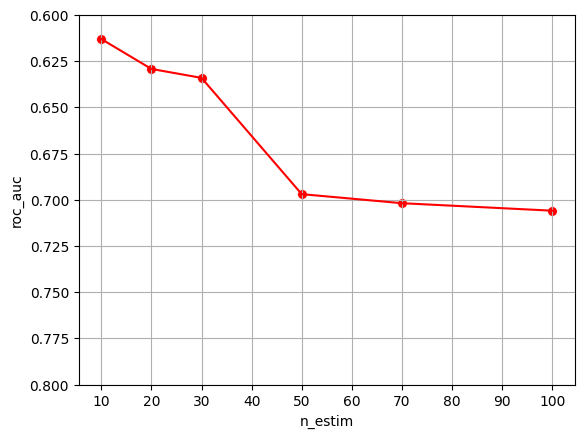

In [54]:
n_estim = [10, 20, 30, 50, 70, 100]
roc_auc = [0.613021, 0.629199, 0.634033, 0.696953, 0.701850, 0.705901]
df_elbow = pd.DataFrame({'n_estim':n_estim, 'roc_auc':roc_auc})
sns.lineplot(x='n_estim', y='roc_auc', data=df_elbow, c='red')
sns.scatterplot(x='n_estim', y='roc_auc', data=df_elbow, s=50, c='red')
plt.ylim(0.8, 0.6)
plt.xticks(ticks=range(10, 110, 10))
plt.grid()

# Reference

Choosing the Right Metric
 - Balanced Classes: Accuracy, F1-Score.
 - Imbalanced Classes: Precision, Recall, F1-Score, ROC-AUC.
 - Probabilistic Predictions: Log Loss, ROC-AUC.

**Accuracy**<br>
The ratio of correctly predicted instances to the total instances.

**Precision**<br> 
The ratio of correctly predicted positive observations to the total predicted positives.

**Recall (Sensitivity)**<br>
The ratio of correctly predicted positive observations to all observations in the actual class.

**F1-Score**<br> 
The weighted average of Precision and Recall.

**ROC-AUC**<br>
Measures the ability of the classifier to distinguish between classes.